<h1> Проект "Модель классификации комментариев"

<h4> Импортируем библиотеки

In [230]:
import pandas as pd # Для работы с данными
import numpy as np # Для работы с массивами
from IPython.display import display # Для отображения DataFrame в Jupyter Notebook
from IPython.core.display import HTML # Для отображения HTML в Jupyter Notebook
import re # Для работы с регулярными выражениями
import nltk # Для работы с текстом
from nltk.corpus import stopwords # Для удаления стоп-слов
from nltk.stem import SnowballStemmer # Для стемминга
from pymorphy2 import MorphAnalyzer  # Для лемматизации
import matplotlib.pyplot as plt # Для визуализации данных
from sklearn.feature_extraction.text import TfidfVectorizer # Для векторизации текста
from sklearn.model_selection import train_test_split # Для разделения данных на обучающую и тестовую выборки
from sklearn.multioutput import MultiOutputClassifier # Для многоклассовой классификации
from sklearn.linear_model import LogisticRegression # Для классификации
from sklearn.metrics import classification_report # Для оценки качества модели
from sklearn.model_selection import GridSearchCV # Для поиска лучших гиперпараметров
from sklearn.metrics import roc_auc_score # Для оценки качества модели
from sklearn.ensemble import RandomForestClassifier # Для классификации
from sklearn.metrics import roc_curve, auc # Для построения ROC-кривой
from sklearn.metrics import f1_score # Для оценки качества модели

<h4> Загружаем датасет

In [231]:
# Открываем файл Excel
file_path = 'dirty_data.xlsx'
data = pd.read_excel(file_path)

<h4> Бинарные колонки классов

In [232]:
phrases = ['Вопрос решен', 'Вопрос не решен', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки']

# Создаем бинарные колонки для каждой фразы
for phrase in phrases:
    data[phrase] = data['taxonomy'].apply(lambda x: 1 if pd.notna(x) and phrase in x else 0)

# Удаляем ненужные колонки
delete_columns = ['annotation_id', 'annotator', 'id', 'created_at', 'taxonomy', 'lead_time', 'updated_at', 'rating']
data.drop(columns=delete_columns, inplace=True)

# Проверяем результат
display(HTML(data.to_html(notebook=True, max_rows=10, max_cols=8)))
print(data.shape)

,comment,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Вопрос не решен
0,спасибо,1,0,0,0,0,0
1,спасибо!,1,0,0,0,0,0
2,Отлично,1,0,0,0,0,0
3,Благодарю за оперативное решение проблемы !,1,0,0,1,0,0
4,Прекрасный специалист! Побольше таких,1,0,1,0,0,0
...,...,...,...,...,...,...,...
2366,"долго, но приятно",1,0,0,0,0,0
2367,16.03.2024 г ребята установили кондиционер. ра...,1,1,1,1,0,0
2368,два дня мусоропровод. сегодня с утра тоже,0,0,0,0,0,1
2369,отрегулировать дверь замки . для должного откр...,0,0,0,0,0,1


(2371, 7)


<h4> Лемматизация

In [233]:
# Инициализация инструментов
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")
stemmer = SnowballStemmer("russian")
morph = MorphAnalyzer()  # Для лемматизации

def preprocess_text(text):
    # Удаление HTML-тегов и спецсимволов
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^а-яА-Я\s]", "", text)
    text = text.lower()
    
    # Лемматизация (лучше, чем стемминг для русского языка)
    tokens = text.split()
    lemmas = [morph.parse(word)[0].normal_form for word in tokens if word not in russian_stopwords]
    
    return " ".join(lemmas)

# Применяем предобработку
data["processed_comment"] = data["comment"].apply(preprocess_text)
# Удаляем пустые строки в колонке processed_comment
data = data[data["processed_comment"].str.strip() != ""]

display(HTML(data.to_html(notebook=True, max_rows=10, max_cols=9)))
print(data.shape)

# Сохраняем результат в новый файл
data.to_excel('cleaned_data.xlsx', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vyacheslav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,comment,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Вопрос не решен,processed_comment
0,спасибо,1,0,0,0,0,0,спасибо
1,спасибо!,1,0,0,0,0,0,спасибо
2,Отлично,1,0,0,0,0,0,отлично
3,Благодарю за оперативное решение проблемы !,1,0,0,1,0,0,благодарить оперативный решение проблема
4,Прекрасный специалист! Побольше таких,1,0,1,0,0,0,прекрасный специалист большой такой
...,...,...,...,...,...,...,...,...
2366,"долго, но приятно",1,0,0,0,0,0,долго приятно
2367,16.03.2024 г ребята установили кондиционер. ра...,1,1,1,1,0,0,г ребята установить кондиционер работа сделать...
2368,два дня мусоропровод. сегодня с утра тоже,0,0,0,0,0,1,день мусоропровод сегодня утро
2369,отрегулировать дверь замки . для должного откр...,0,0,0,0,0,1,отрегулировать дверь замок должный открывание ...


(2355, 8)


<h4> Балансировка классов

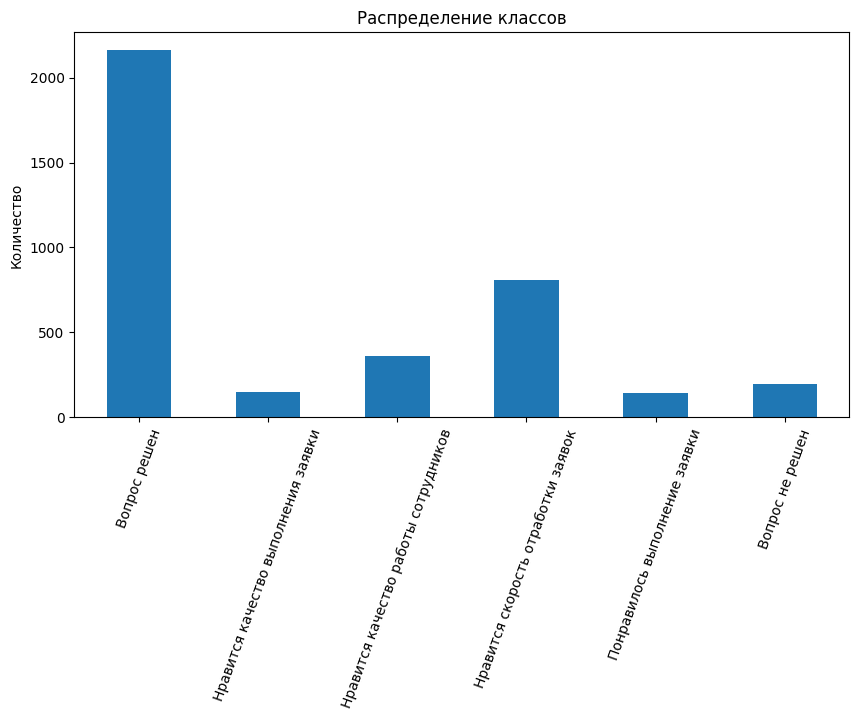

In [234]:
# Проверка распределения классов
class_columns = data.columns[1:-1]  # Столбцы B-H (предполагаем, что последний столбец обработанный текст)
class_distribution = data[class_columns].sum()

# Визуализация
plt.figure(figsize=(10, 5))
class_distribution.plot(kind="bar", rot=70)
plt.title("Распределение классов")
plt.ylabel("Количество")
plt.show()

<h4> Векторизация данных

In [235]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X = vectorizer.fit_transform(data["processed_comment"]) # Признаки (комментарии)
y = data.drop(columns=["comment", "processed_comment"])  # Все целевые столбцы (метки классов)

<h4> Гиперпараметры "GridSearchCV" c моделью "LogisticRegression"

In [236]:
X_train, X_test, y_train, y_test = train_test_split(
    X,          # Признаки (векторизованные комментарии)
    y,          # Целевые переменные (метки классов)
    test_size=0.2,    # 20% данных → тест, 80% → обучение
    random_state=42    # Фиксирует случайность для воспроизводимости
)

# Задаём параметры для LogisticRegression
param_grid = {
    'estimator__C': [1], 
    'estimator__penalty': ['l2'],
    'estimator__solver': ['liblinear']
}

grid = GridSearchCV(
    MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced')),
    param_grid, # Параметры для поиска
    cv=3, # 3-кратная кросс-валидация
    scoring='f1_macro' # Оценка по F1-мере
)

grid.fit(X_train, y_train) # Обучение модели с использованием GridSearchCV

y_pred = grid.predict(X_test) # Предсказания на тестовой выборке
print(classification_report(y_test, y_pred, target_names=y.columns)) # Отчет о классификации

# ROC-AUC для каждого класса
y_proba = grid.predict_proba(X_test)
# predict_proba возвращает список массивов, нужно собрать вероятности для каждого класса
y_proba_matrix = np.column_stack([proba[:, 1] for proba in y_proba])
roc_auc_macro = roc_auc_score(y_test, y_proba_matrix, average="macro") # ROC-AUC для многоклассовой классификации
print(f"ROC-AUC: {roc_auc_macro:.4f}")
print("Среднее F1-score:", round(f1_score(y_test, y_pred, average="macro"), 3))

                                      precision    recall  f1-score   support

                        Вопрос решен       0.99      0.91      0.95       432
 Нравится качество выполнения заявки       0.45      0.75      0.56        24
Нравится качество работы сотрудников       0.57      0.83      0.68        71
  Нравится скорость отработки заявок       0.91      0.94      0.92       164
       Понравилось выполнение заявки       0.17      0.39      0.24        28
                     Вопрос не решен       0.49      0.95      0.64        39

                           micro avg       0.79      0.89      0.84       758
                           macro avg       0.60      0.80      0.67       758
                        weighted avg       0.86      0.89      0.86       758
                         samples avg       0.82      0.88      0.83       758

ROC-AUC: 0.9076
Среднее F1-score: 0.666


<h4> ROC-AUC кривые классов модели "LogisticRegression"

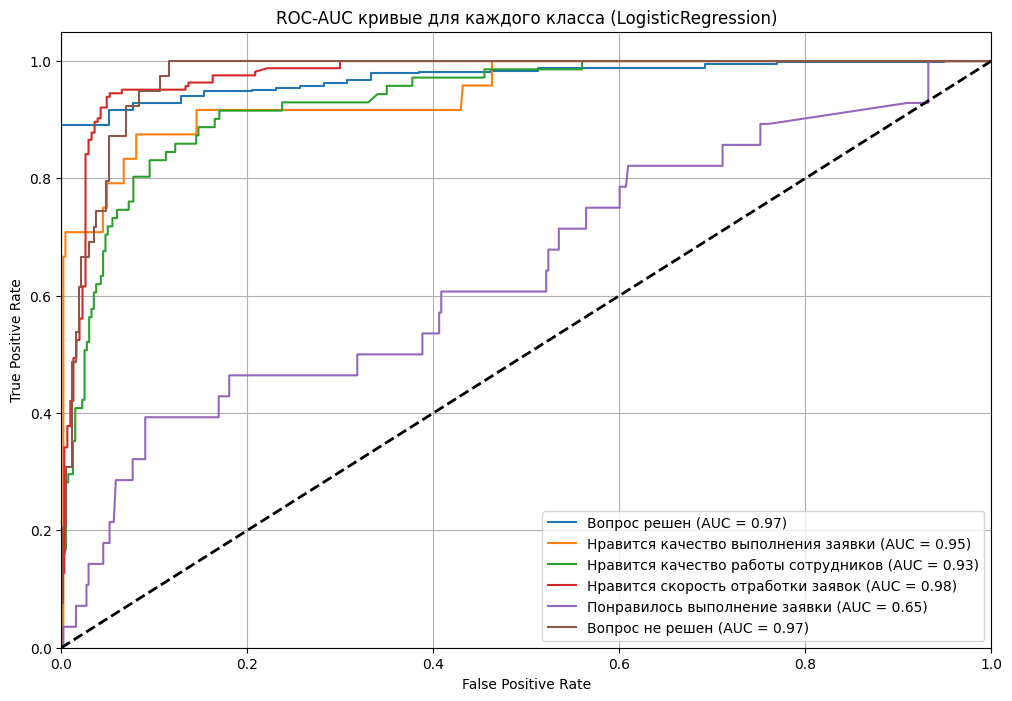

In [237]:
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(y.columns):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_proba_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC кривые для каждого класса (LogisticRegression)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<h4> Гиперпараметры "GridSearchCV" c моделью "RandomForest"

In [238]:
# Задаём параметры для RandomForest
param_grid_rf = {
    'estimator__n_estimators': [200],
    'estimator__max_depth': [None],
    'estimator__min_samples_split': [5]
    }

# Создаём GridSearchCV с RandomForest
grid_rf = GridSearchCV(
    MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42)),
    param_grid_rf, # Параметры для поиска
    cv=3, # 3-кратная кросс-валидация
    scoring='f1_macro' # Оценка по F1-мере
)

grid_rf.fit(X_train, y_train) # Обучение модели с использованием GridSearchCV

y_pred_rf = grid_rf.predict(X_test) # Предсказания на тестовой выборке
print(classification_report(y_test, y_pred_rf, target_names=y.columns)) # Отчет о классификации

# ROC-AUC для RandomForest
y_proba_rf = grid_rf.predict_proba(X_test)
# predict_proba возвращает список массивов, нужно собрать вероятности для каждого класса
y_proba_matrix_rf = np.column_stack([proba[:, 1] for proba in y_proba_rf])
roc_auc_macro_rf = roc_auc_score(y_test, y_proba_matrix_rf, average="macro") # ROC-AUC для многоклассовой классификации
print(f"ROC-AUC: {roc_auc_macro_rf:.4f}")
print("Среднее F1-score:", round(f1_score(y_test, y_pred_rf, average="macro"), 3))

                                      precision    recall  f1-score   support

                        Вопрос решен       0.97      0.98      0.98       432
 Нравится качество выполнения заявки       0.68      0.71      0.69        24
Нравится качество работы сотрудников       0.71      0.65      0.68        71
  Нравится скорость отработки заявок       0.92      0.93      0.93       164
       Понравилось выполнение заявки       0.33      0.07      0.12        28
                     Вопрос не решен       0.77      0.69      0.73        39

                           micro avg       0.91      0.88      0.90       758
                           macro avg       0.73      0.67      0.69       758
                        weighted avg       0.89      0.88      0.88       758
                         samples avg       0.92      0.90      0.90       758

ROC-AUC: 0.9027
Среднее F1-score: 0.687


<h4> ROC-AUC кривые классов модели "RandomForest"

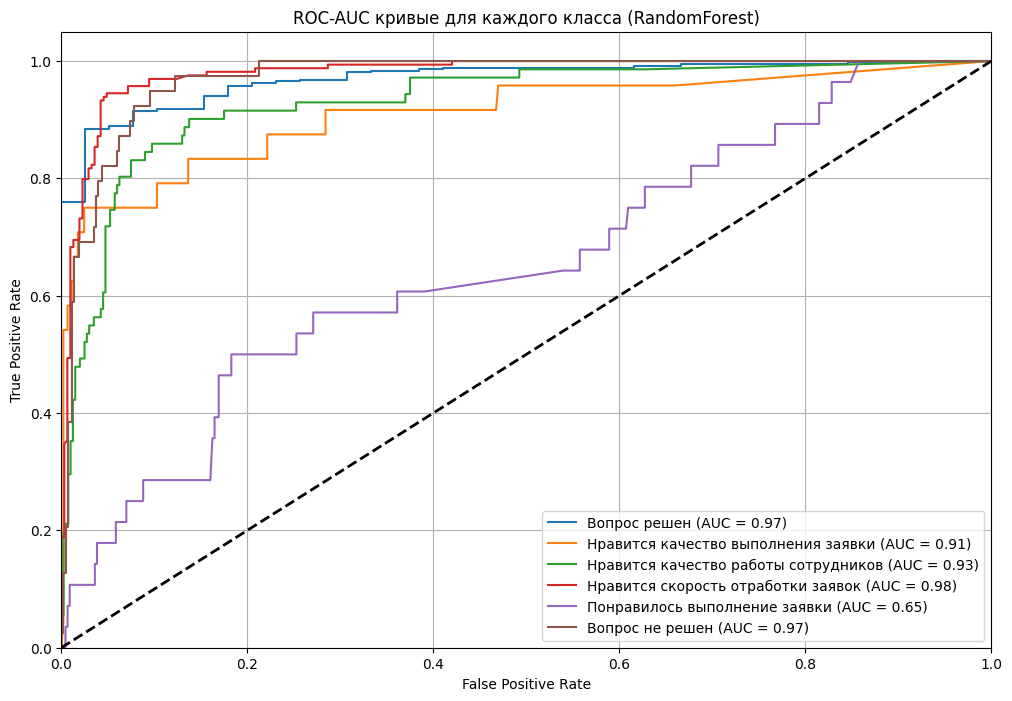

In [239]:
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(y.columns):
    fpr_rf, tpr_rf, _ = roc_curve(y_test.iloc[:, i], y_proba_matrix_rf[:, i])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, label=f'{class_name} (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC кривые для каждого класса (RandomForest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()